In [1]:
%run ../data_preparation.ipynb

Number of finding labels: 16297
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Labels (7) [('Atelectasis', 692), ('Effusion', 700), ('Infiltration', 2292), ('Mass', 310), ('Nodule', 441), ('Pleural_Thickening', 207), ('Pneumothorax', 445)]


In [2]:
# Splitting data into training and validation sets.
from sklearn.model_selection import train_test_split
training_df, validation_df = train_test_split(xray_labels_df, 
                                              test_size = 0.25, 
                                              random_state = 2018,
                                              stratify = xray_labels_df['Finding Labels'].map(lambda x: x[:4]))

print('train', training_df.shape[0], 'validation', validation_df.shape[0])

train 6000 validation 2000


In [3]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip=True,
                              vertical_flip=True,
                              height_shift_range=0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

C:\Users\AJ\Anaconda3\envs\csc665\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    # df_gen is an iterator that yields a tuple (X,Y). 
    # X = batch of images, and Y = corresponding labels.
    return df_gen
    

In [6]:
# Generates training and validation data to be used by models.
training_gen = flow_from_dataframe(core_idg, training_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 32)
validation_gen = flow_from_dataframe(core_idg, validation_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 256)

test_X, test_Y = next(flow_from_dataframe(core_idg, validation_df, path_col ='path', y_col ='disease_vec', target_size = IMG_SIZE, color_mode = 'grayscale', batch_size = 1024))
t_x, t_y = next(training_gen)


Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


In [7]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf

base_mobilenet_model = MobileNet(input_shape = t_x.shape[1:],
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss ='binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 3,756,679
Trainable params: 3,734,791
Non-trainable params: 21,888
_____________________________________________________________

#### Setting model checkpoint.
#### Monitoring validation loss with patience of 10, meaning the model will stop training if after 10 epochs it does not see an improvement in val_loss.

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights_sigmoid_128x128.best.hdf5".format("xray_class")

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)

callbacks_list = [checkpoint, early]

In [9]:
history = multi_disease_model.fit_generator(training_gen, 
                                            steps_per_epoch=100,
                                            validation_data = (test_X, test_Y), 
                                            epochs = 1, 
                                            callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 150s 1s/step - loss: 0.4065 - binary_accuracy: 0.8875 - mean_absolute_error: 0.1539 - val_loss: 1.0996 - val_binary_accuracy: 0.9111 - val_mean_absolute_error: 0.0931

Epoch 00001: val_loss improved from inf to 1.09960, saving model to xray_class_weights_sigmoid_128x128.best.hdf5


In [11]:
multi_disease_model.load_weights(weight_path)

In [12]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 2s 2ms/step


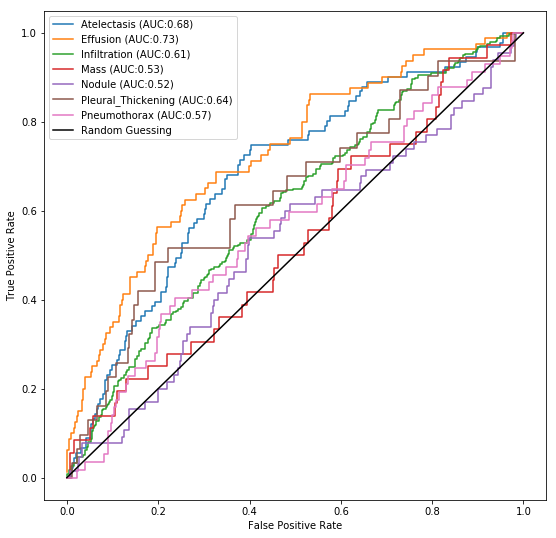

In [34]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net_sigmoid_128x128.png')

### Model was able to train for 41 epochs before it stopped early. We believe this is the local minimum of the loss function.

In [24]:
history = multi_disease_model.fit_generator(training_gen, 
                                            steps_per_epoch = 100,
                                            validation_data =  (test_X, test_Y), 
                                            epochs = 100, 
                                            callbacks = callbacks_list)

Epoch 1/100
100/100 [==============================] - 80s 803ms/step - loss: 0.2730 - binary_accuracy: 0.9096 - mean_absolute_error: 0.1504 - val_loss: 0.2721 - val_binary_accuracy: 0.9111 - val_mean_absolute_error: 0.1481

Epoch 00001: val_loss improved from inf to 0.27209, saving model to xray_class_weights_sigmoid_128x128.best.hdf5
Epoch 2/100
100/100 [==============================] - 123s 1s/step - loss: 0.2767 - binary_accuracy: 0.9077 - mean_absolute_error: 0.1538 - val_loss: 0.2701 - val_binary_accuracy: 0.9111 - val_mean_absolute_error: 0.1464

Epoch 00002: val_loss improved from 0.27209 to 0.27008, saving model to xray_class_weights_sigmoid_128x128.best.hdf5
Epoch 3/100
100/100 [==============================] - 82s 821ms/step - loss: 0.2699 - binary_accuracy: 0.9098 - mean_absolute_error: 0.1492 - val_loss: 0.2754 - val_binary_accuracy: 0.9110 - val_mean_absolute_error: 0.1416

Epoch 00003: val_loss did not improve
Epoch 4/100
100/100 [==============================] - 105s


Epoch 00029: val_loss improved from 0.26336 to 0.26208, saving model to xray_class_weights_sigmoid_128x128.best.hdf5
Epoch 30/100
100/100 [==============================] - 44s 442ms/step - loss: 0.2625 - binary_accuracy: 0.9091 - mean_absolute_error: 0.1484 - val_loss: 0.2660 - val_binary_accuracy: 0.9111 - val_mean_absolute_error: 0.1388

Epoch 00030: val_loss did not improve
Epoch 31/100
100/100 [==============================] - 44s 443ms/step - loss: 0.2671 - binary_accuracy: 0.9075 - mean_absolute_error: 0.1497 - val_loss: 0.2632 - val_binary_accuracy: 0.9111 - val_mean_absolute_error: 0.1424

Epoch 00031: val_loss did not improve
Epoch 32/100
100/100 [==============================] - 45s 446ms/step - loss: 0.2619 - binary_accuracy: 0.9096 - mean_absolute_error: 0.1467 - val_loss: 0.2603 - val_binary_accuracy: 0.9110 - val_mean_absolute_error: 0.1423

Epoch 00032: val_loss improved from 0.26208 to 0.26028, saving model to xray_class_weights_sigmoid_128x128.best.hdf5
Epoch 33/10

In [25]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 1s 1ms/step


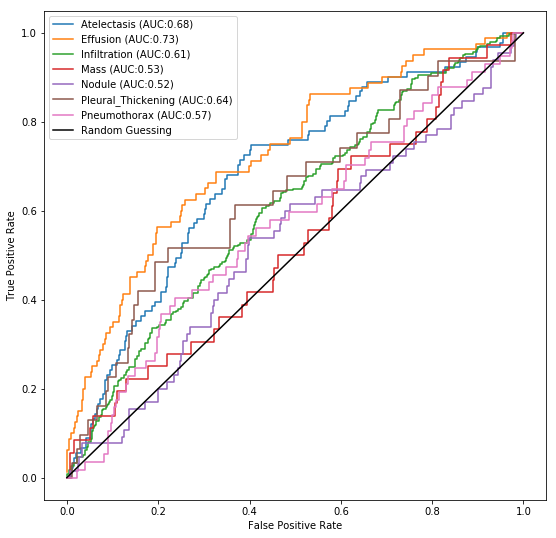

In [33]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('roc_42epochs_sigmoid_128x128.png')

In [19]:
print(history.history.keys())

dict_keys(['binary_accuracy', 'val_binary_accuracy', 'val_mean_absolute_error', 'val_loss', 'loss', 'mean_absolute_error'])


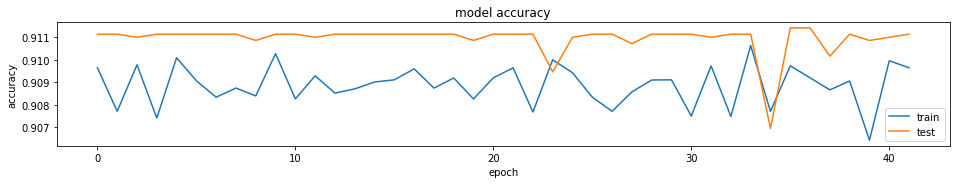

In [35]:
plt.figure(1, figsize = (16,5))
plt.subplot(211)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

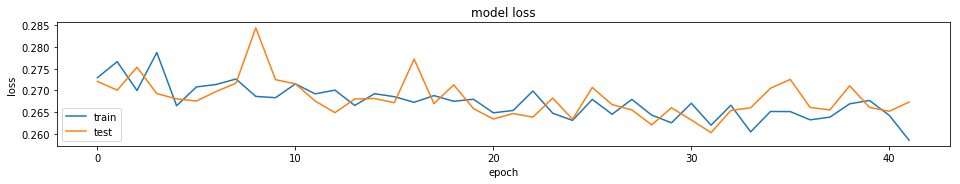

In [36]:
plt.figure(1, figsize = (16,5))
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')

In [31]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 8.89%, PDx: 9.88%
Effusion: Dx: 7.81%, PDx: 9.62%
Infiltration: Dx: 27.05%, PDx: 29.50%
Mass: Dx: 3.52%, PDx: 3.15%
Nodule: Dx: 6.35%, PDx: 3.95%
Pleural_Thickening: Dx: 3.03%, PDx: 2.03%
Pneumothorax: Dx: 5.57%, PDx: 4.19%


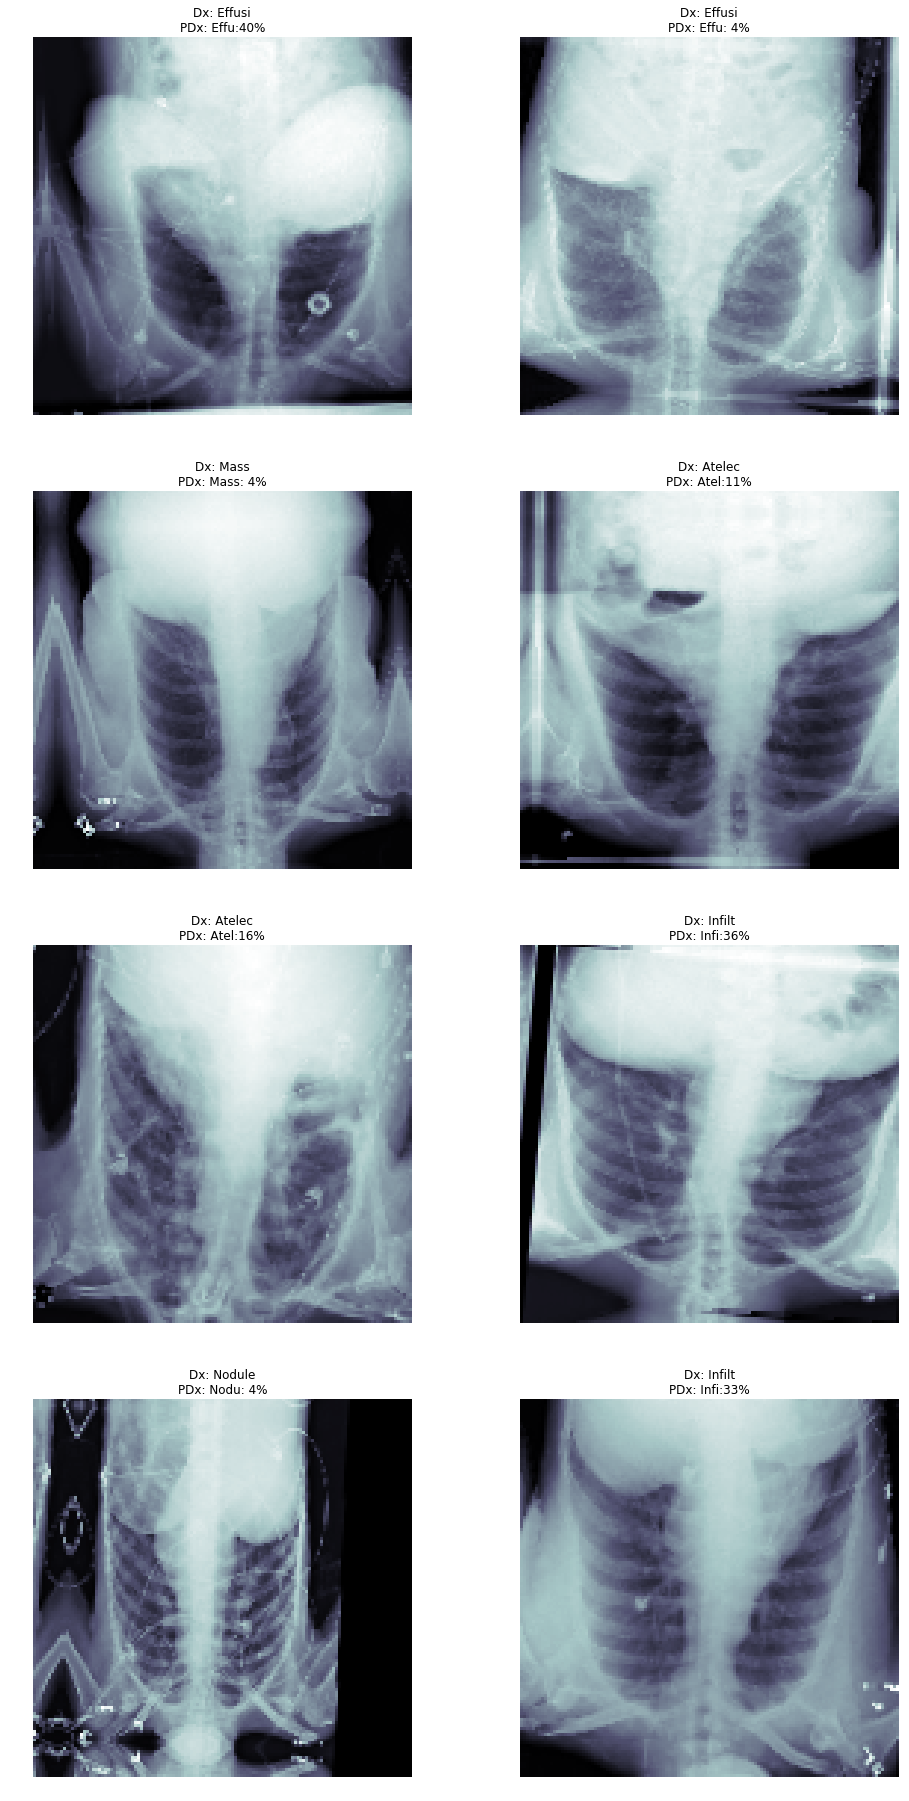

In [29]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')